In [1]:
%load_ext autoreload
%autoreload 2

import json
import pyhf
pyhf.set_backend('jax')

import pymc as pm
import arviz as az

import numpy as np

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op

# import aesara
import aesara.tensor as at
# from aesara.graph.op import Op
from aesara.link.jax.dispatch import jax_funcify

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp


# import sys
# sys.path.insert(1, '/Users/malinhorstmann/Documents/pyhf_pymc/src')
import MH_inference
import HMC_inference
import prepare_inference

import matplotlib.pyplot as plt

### Model

In [2]:
### Simple pyhf model
model = pyhf.Model(
    {'channels': [{'name': 'singlechannel',
    'samples': [
    {'name': 'signal',
     'data': [6, 6, 3],
     'modifiers': [
         {'name': 'mu', 'type': 'normfactor', 'data': None}]},

    {'name': 'background',
     'data': [55, 55, 55],
     'modifiers': [
        ## Staterror / Normal
        {"name": "my_staterror","type": "staterror","data": [2.0, 2.0, 2.4],},
        ## Lumi / Normal
        {'name': 'lumi', 'type': 'lumi', 'data': None},
        ## Correlated / Normal
        {'name': 'corr_bkg', 'type': 'histosys','data': {'hi_data': [65, 56, 67], 'lo_data': [40, 40, 43]}},
        {'name': 'corr_bkg1', 'type': 'histosys','data': {'hi_data': [65, 65, 66], 'lo_data': [40, 40, 40]}},
        {'name': 'corr_bkg2', 'type': 'histosys','data': {'hi_data': [66, 65, 60], 'lo_data': [40, 40, 39]}},
        ## Uncorrelated / Poisson
        {'name': 'uncorr_bkg', 'type': 'shapesys','data': [7, 8, 7.17]},
        {'name': 'uncorr_bkg1', 'type': 'shapesys','data': [7, 8, 6.7]},
        {'name': 'uncorr_bkg2', 'type': 'shapesys','data': [7.27, 9, 7]},
        
         ]},    
                                 
    ]},
    ],
    "parameters": [
            {
                "name": "lumi",
                "auxdata": [1.0],
                "sigmas": [0.017],
                "bounds": [[0.915, 1.085]],
                "inits": [1.0],
            }
        ],}
)

nBins = len(model.expected_actualdata(model.config.suggested_init()))

# nPars = len(model.config.suggested_init())

### Observations
obs = model.expected_actualdata(model.config.suggested_init())

In [3]:
with open('SRee_SRmm_Srem.json') as serialized:
# with open('ttbar_ljets_xsec_inclusive_pruned.json') as serialized:
    spec = json.load(serialized)

workspace = pyhf.Workspace(spec)
model = workspace.model()
obs = workspace.data(model, include_auxdata=False)
nBins = len(model.expected_actualdata(model.config.suggested_init()))
nPars = len(model.config.suggested_init())

In [3]:
# Prepare the priors for sampling
    # Unconstrained parameters
unconstr_dict = {
    'uncon1': {'type': 'unconstrained', 'type2': 'normal', 'input': [[1], [0.1]]}
    }

    # Create dictionary with all priors (unconstrained, constrained by normal and poisson)
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)

    # dictionary with keys 'model', 'obs', 'priors', 'precision'
prepared_model = prepare_inference.prepare_model(model=model, observations=obs, precision=1, priors=prior_dict)

## HMC

### General Stuff

In [4]:
@jax.jit
def processed_expData(parameters):
    a = jnp.stack([model.expected_actualdata(parameters)[i] for i in range(nBins)])
    return a

@jax.jit
def vjp_expData(parameters, vector):
    _,back = jax.vjp(processed_expData, parameters)
    return back(vector)

one_vector = np.full(nBins, 1., dtype='float64')

### Gradient Op

In [5]:
class VJPOp(Op):

    def make_node(self, vjp_func, parameters, vector):
        a = np.linspace(0.01, 1, nBins).tolist()
        pars = at.as_tensor_variable(a)
        self.vjp_func = vjp_expData
        inputs = [pt.as_tensor_variable(parameters), pt.as_tensor_variable(vector)]
        outputs = [inputs[0].type()]
        # outputs = [pt.vector()]
        
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        (parameters, vector) = inputs
        results = vjp_expData(parameters, vector)

        if not isinstance(results, (list, tuple)):
                results = (results,)
                
        for i, r in enumerate(results):
            outputs[i][0] = np.asarray(r)

vjp_op = VJPOp()

In [6]:
a = np.linspace(0.01, 1, 17).tolist()
# pars = at.as_tensor_variable(a)
vjp_op(vjp_expData, a, one_vector).eval()

array([ 1.00045622,  1.13226096,  0.91256731, 27.39944597, 15.        ,
        3.44782954,  4.50467934,  5.73530507,  2.18049616,  3.02960793,
        4.04207882,  1.59442615,  2.28227109,  3.12074543,  1.25666255,
        1.83068248,  2.54145706])

### Non-Gradient Op (with `grad` method)

In [7]:
class MyOp(Op):
    
    def make_node(self, func, parameters):
        self.func = processed_expData
        inputs = [pt.as_tensor_variable(parameters)]
        # outputs = [inputs[0].type()]
        outputs = [pt.vector()]

        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        (parameters, ) = inputs
        results = processed_expData(parameters)

        if len(outputs) == 1:
                outputs[0][0] = np.asarray(results)
                return
        for i, r in enumerate(results):
                outputs[i][0] = np.asarray(r)

    def grad(self, vjp_func, parameters, vector):
        return [vjp_custom_op(vjp_func, parameters, vector)]
        
my_op = MyOp()

In [8]:
pars = prepare_inference.priors2pymc(prepared_model)
my_op(processed_expData, pars).eval()

array([81.68245171, 76.40679514, 68.46281936])

### Sampling

In [9]:
with pm.Model():
    pars = prepare_inference.priors2pymc(prepared_model)
    # mu = my_op.grad(processed_expData, pars, one_vector)[0].eval()
    mu = my_op(processed_expData, pars).eval()
    main = pm.Normal("main", mu=mu, sigma=1, observed=obs)
    
    post_data = pm.sample(500)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(500)

print(model.expected_actualdata(model.config.suggested_init()))
az.summary(post_pred, var_names="main")

/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitte

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


Sampling: [Gammas, Normals, Unconstrained, main]


[61. 61. 58.]


/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/stats/stats.py:1351: UserWarning: Selecting first found group: posterior_predictive
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
main[0],53.137,0.998,51.254,54.970,0.022,0.016,1985.0,1913.0,1.0
main[1],49.351,0.990,47.513,51.232,0.022,0.016,1955.0,1933.0,1.0
main[2],53.117,0.993,51.290,54.985,0.022,0.016,1972.0,1856.0,1.0


## Metropolis-Hasting

In [10]:
MetrHast_post_data, MetrHast_post_pred, MetrHast_prior_pred = MH_inference.sampling(prepared_model, 500)

print(model.expected_actualdata(model.config.suggested_init()))
az.summary(MetrHast_post_pred, var_names="main")

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [Unconstrained]
>Metropolis: [Normals]
>Metropolis: [Gammas]
CompoundStep
>Metropolis: [Unconstrained]
>Metropolis: [Normals]
>Metropolis: [Gammas]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


Sampling: [Gammas, Normals, Unconstrained, main]


[61. 61. 58.]


/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/stats/stats.py:1351: UserWarning: Selecting first found group: posterior_predictive
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
main[0],61.128,1.417,58.428,63.750,0.065,0.046,481.0,1135.0,1.01
main[1],61.000,1.448,58.442,63.896,0.063,0.044,538.0,1036.0,1.01
main[2],57.831,1.473,54.817,60.434,0.103,0.073,209.0,1143.0,1.03


## Plotting

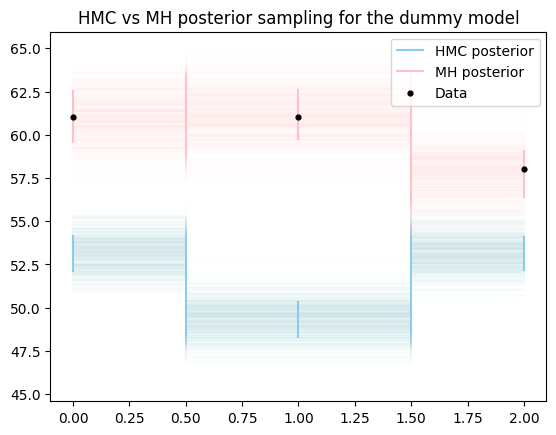

In [11]:
# plt.step(np.linspace(0,nBins-1,nBins),prior_pred.prior_predictive.main[0].T, alpha = 0.01, c = 'steelblue', where = 'mid');
# plt.vlines(np.arange(nBins),*np.quantile(prior_pred.prior_predictive.main[0],[.15,.85],axis=0), colors = 'steelblue', label='HMC prior');

    ## Posterior predictive
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.main[0].T, alpha = 0.01, c = 'skyblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.main[0],[.15,.85],axis=0), colors = 'skyblue', label='HMC posterior')

plt.step(np.linspace(0,nBins-1,nBins),MetrHast_post_pred.posterior_predictive.main[0].T, alpha = 0.01, c = 'pink', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(MetrHast_post_pred.posterior_predictive.main[0],[.15,.85],axis=0), colors = 'pink', label='MH posterior')

    ## Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "Data")
plt.legend(loc='upper right')

plt.title(f'HMC vs MH posterior sampling for the dummy model')

# plt.savefig(f'HMC_MH_dummy')
plt.show()

## Testing

In [3]:
### Preprocess the model.expected_actualdata
def processedData(p):
    # a = jnp.stack([jax.jit(model.expected_actualdata(p))[i] for i in range(nBins)])
    a = jnp.stack([model.expected_actualdata(p)[i] for i in range(nBins)])
    return a

### 

In [4]:
from aesara.graph.op import Op
def make_op(func, itypes, otypes):
    @jax.jit
    def vjp_func(fwd_inputs, vector):
        _,back = jax.vjp(func,fwd_inputs)
        return back(vector)

    class JaxVJPOp(Op):
        __props__ = ("jax_vjp_func",)

        def __init__(self):
            self.jax_vjp_func = vjp_func
            self.itypes = itypes + otypes
            self.otypes = itypes
            super().__init__()

        def perform(self, node, inputs, outputs):

            results = self.jax_vjp_func(*(jnp.asarray(x) for x in inputs))

            if not isinstance(results, (list, tuple)):
                results = (results,)

            for i, r in enumerate(results):
                outputs[i][0] = np.asarray(r)


    jax_grad_op = JaxVJPOp()
                
    @jax_funcify.register(JaxVJPOp)
    def jax_funcify_JaxGradOp(op):
        return op.jax_vjp_func

    @jax.jit
    def fwd_func(fwd_inputs):
        return func(fwd_inputs)
    
    class JaxOp(Op):
        __props__ = ("fwd_func",)

        def __init__(self):
            self.fwd_func = fwd_func
            self.itypes = itypes
            self.otypes = otypes
            super().__init__()

        def perform(self, node, inputs, outputs):
            results = self.fwd_func(*(jnp.asarray(x) for x in inputs))
            if len(outputs) == 1:
                outputs[0][0] = np.asarray(results)
                return
            for i, r in enumerate(results):
                outputs[i][0] = np.asarray(r)

        def grad(self, inputs, vectors):
            return [jax_grad_op(inputs[0], vectors[0])]

    @jax_funcify.register(JaxOp)
    def jax_funcify_JaxOp(op):
        return op.fwd_func

    jax_op = JaxOp()
    
    return jax_op, jax_grad_op

In [7]:

### Appling the Op to model.expected_actualdata
op, grad_op = make_op(
    processedData,
    (at.TensorType(dtype=np.float64, shape=(9,)),),
    (at.TensorType(dtype=np.float64, shape=(nBins,)),),
)

### Test for some array of input parameters
a = np.linspace(0.01, 1, 9).tolist()
pars = at.as_tensor_variable(a)
op(pars).eval()

array([17.37026822, 20.12555632, 21.17238316])